# Prerequisites
This tutorial requires installing the [pynwb](http://pynwb.readthedocs.io/en/latest/getting_started.html#installation) and the [allensdk](http://alleninstitute.github.io/AllenSDK/install.html)
!pip install -q allensdk
!pip install -q pynwb

In [2]:
import warnings

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
mpl.style.use('seaborn-notebook')
from matplotlib import pyplot as plt

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as si
import pynwb

In [3]:
brain_observatory_cache_manifest_file = 'boc/manifest.json'

# Quick Start

In [4]:
ophys_experiment_id = 570014520
boc = BrainObservatoryCache(manifest_file=brain_observatory_cache_manifest_file)
exp = boc.get_ophys_experiment_data(ophys_experiment_id)
legacy_map = pynwb.legacy.get_type_map()
io2 = pynwb.NWBHDF5IO(exp.nwb_file, extensions=legacy_map, mode='r')
with warnings.catch_warnings(record=True) as w:
    nwb_data = io2.read() 

# Using allensdk to access the Brain Observatory:
This notebook documents the use of  [pynwb](http://pynwb.readthedocs.io/en/latest/). The [allensdk](http://alleninstitute.github.io/AllenSDK/) provides functionality to download and cache Neurodata Without Borders (nwb) files associated with experiments from the [Brain Observatory](http://observatory.brain-map.org/visualcoding/).

To begin, we use the allensdk to download the Brain Observatory experiment containers.  The experiment container describes a set of experiments performed with the same targeted area, imaging depth, and Cre line.  


if you find an experiment in the Brain Observatory using the interactive website: [http://observatory.brain-map.org/visualcoding/search/overview](http://observatory.brain-map.org/visualcoding/search/overview), you can just set the container id manually.  For example, container `580051757` is summarized at a glance [here](http://observatory.brain-map.org/visualcoding/search/experiment?id=580051757); to get data for this container we would input the container id directly:

In [5]:
boc = BrainObservatoryCache(manifest_file=brain_observatory_cache_manifest_file)
ophys_experiment_list = boc.get_ophys_experiments(experiment_container_ids=[569811199])
pd.DataFrame(ophys_experiment_list)

,acquisition_age_days,cre_line,donor_name,experiment_container_id,fail_eye_tracking,id,imaging_depth,reporter_line,session_type,specimen_name,targeted_structure
0,159,Nr5a1-Cre,279430,569811199,False,570014520,300,Ai93(TITL-GCaMP6f),three_session_B,Nr5a1-Cre;Camk2a-tTA;Ai93-279430,VISp
1,157,Nr5a1-Cre,279430,569811199,True,569811201,300,Ai93(TITL-GCaMP6f),three_session_A,Nr5a1-Cre;Camk2a-tTA;Ai93-279430,VISp
2,160,Nr5a1-Cre,279430,569811199,True,570087662,300,Ai93(TITL-GCaMP6f),three_session_C2,Nr5a1-Cre;Camk2a-tTA;Ai93-279430,VISp


Each of these three "ophys experiments" corresponds to a single 2-photon microscopy recording session. In each container, the particular visual stimulus that was presented is indicated by the `session_type`.  Each `session_type` contains several diffferent stimulus sets; for more information, take a look at the [whitepaper](http://help.brain-map.org/display/observatory/Data+-+Visual+Coding).

Lets use pynwb to load the data from `three_session_B`. If this is the first time through this notebook this might take a minute to download these files, and will require approximately 300Mb of total disk space for the three nwb files: 

In [6]:
print('Getting nwb file for ophys experiment: %s' % 570014520)
nwb_file_name = boc.get_ophys_experiment_data(570014520).nwb_file
print('   nwb data stored in: %s' % nwb_file_name)

Getting nwb file for ophys experiment: 570014520
   nwb data stored in: /Users/nicholasc/pynwb/docs/notebooks/boc/ophys_experiment_data/570014520.nwb


# Reading legacy nwb files with pynwb:
Now that we have downloaded the nwb files using the `BrainObservatoryCache`, we can use pynwb to load the data and take a peek inside. Because this file was created from [version 1.0 of the NWB Schema](https://github.com/NeurodataWithoutBorders/specification/blob/master/version_1.0.6/NWB_file_format_specification_1.0.6.pdf>), we have to use a object called a type map to help the [NWB 2.0 schema](http://nwb-schema.readthedocs.io/en/latest/format.html) interpret the data in the "legacy" file. Alot has changed in the transition from NWB 1.0 to 2.0, including a more modular software architecture, a simplified (and extended)  specification language, a mechanism for easy creation of custom schema extensions ([Click here for more information](http://www.nwb.org/2017/09/06/what-is-new-in-nwbn-v2-0/)).

In [7]:
legacy_map = pynwb.legacy.get_type_map()

Now we can create a reader object, and load the data:

In [8]:
nwbio = pynwb.NWBHDF5IO(nwb_file_name, extensions=legacy_map, mode='r')
    
# If nwb_version < 2.0, some warnings will be thrown; this is expected behavior
with warnings.catch_warnings(record=True) as w:  
    nwb_data = nwbio.read()

Lets take a peek inside one of the nwb file objects and see how to access some of its data: 

In [9]:
print(nwb_data.institution)
print(nwb_data.identifier)
print(nwb_data.session_description)
print(nwb_data.session_start_time)
print(nwb_data.session_id)

Allen Institute for Brain Science
Brain Observatory Visual Coding Experiment 570014520; NWB-1.0.5; Fri May 19 08:23:57 2017
2-photon recording of visual areas in head-fixed mouse with visual stimulus
Thu Feb 16 16:00:07 2017
570014520


We can query the stimuli that were presented during the session:

In [10]:
pd.DataFrame( [stimulus.description for stimulus in nwb_data.stimulus])

,0
0,natural_movie_one_stimulus
1,natural_scenes_stimulus
2,static_gratings_stimulus
3,spontaneous_stimulus


The `natural_movie_one_stimulus` is an example of an [ImageSeries](http://pynwb.readthedocs.io/en/latest/pynwb.image.html#pynwb.image.IndexSeries>). An ImageSeries stores the indices-to-image-frames relationships inside an associated `index_timeseries`. This allows the static image template stack to be stored somewhere else, and the images in the stack to be referenced out-of-order. The data field stores the index of the frame in the referenced ImageSeries, and the timestamps array indicates when that image was displayed. 

In [11]:
natural_movie_one_stimulus = nwb_data.get_stimulus('natural_movie_one_stimulus')
stim_table = pd.DataFrame({'data':natural_movie_one_stimulus.data.value, 
                           'timestamps':natural_movie_one_stimulus.timestamps.value})
stim_table.head()

,data,timestamps
0,0,2346.39460
1,1,2346.42786
2,2,2346.46112
3,3,2346.49437
4,4,2346.52763


Lets use the allensdk to plot one of these image templates from one of the natural movies that was shown during this session.  The template is has an original shape of 304x608 pixels, however this source image is stretched to fit on a 1200x1920 monitor, and warped so that scene appears flat from the perspective of the viewer, whos eye is close to the screen.  For more information about the Brain Observatory Stimulus, check out the [stimulus whitepaper](http://help.brain-map.org/download/attachments/10616846/VisualCoding_VisualStimuli.pdf)

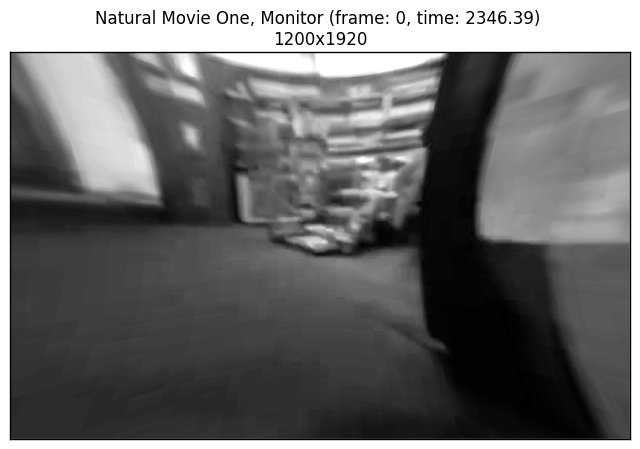

In [12]:
frame, timestamp = stim_table.iloc[0]['data'], stim_table.iloc[0]['timestamps']
image = natural_movie_one_stimulus.indexed_timeseries.data.value[int(frame),:,:]
m = si.BrainObservatoryMonitor()
fig, ax = plt.subplots(1,1, figsize=(10,5))
m.show_image(m.natural_movie_image_to_screen(image, origin='upper'), ax=ax,origin='upper', warp=True, show=False)
_ = ax.set_title('Natural Movie One, Monitor (frame: %i, time: %5.2f) \n1200x1920' % (frame, timestamp))

Now that we have explored what was shown to the animal, what can we find out about the data that was recorded?  Lets start off by gathering a summary of the metadata related to the imaging plane:

In [13]:
for two_photon_series in nwb_data.acquisition:
    print(two_photon_series.description)
    print(two_photon_series.dimension.value)
    print(two_photon_series.field_of_view.value)
    
    imaging_plane = two_photon_series.imaging_plane
    print(imaging_plane.name)
    print(imaging_plane.location)
    print(imaging_plane.device)
    print(imaging_plane.imaging_rate)
    print(imaging_plane.indicator)
    print(imaging_plane.excitation_lambda)
    print(two_photon_series.bits_per_pixel)
    
dimension = two_photon_series.dimension.value
field_of_view = two_photon_series.field_of_view.value

Unprocessed in-vivo two-photon calcium imaging of neuronal activity
[512 512]
[ 0.0004  0.0004]
imaging_plane_1
VISp
2-photon microscope
31Hz
GCaMP6f
910 nanometers
8


Next, lets see what processed data associated with this experiment is available.  Lets call up the `brain_observatory_pipeline` processing module:

In [14]:
pipeline = nwb_data.get_processing_module('brain_observatory_pipeline')
for container in pipeline.containers:
    print(container.name)

MotionCorrection
DfOverF
Fluorescence
BehavioralTimeSeries
ImageSegmentation
PupilTracking
EyeTracking


Each of these modules contain the result of some processing of raw data signals acquired during the session (For more information on the processing, check out the Brain Observatory [whitepaper](http://help.brain-map.org/download/attachments/10616846/VisualCoding_Overview.pdf)). Now that we know the types of processed signals, lets start with some behavioral measurements from the experiment. We can look at the running speed of the animal (`BehavioralTimeSeries`), as well as information about pupil size and eye position obtained by processing a standard camera recording the gaze of the eye during the session:

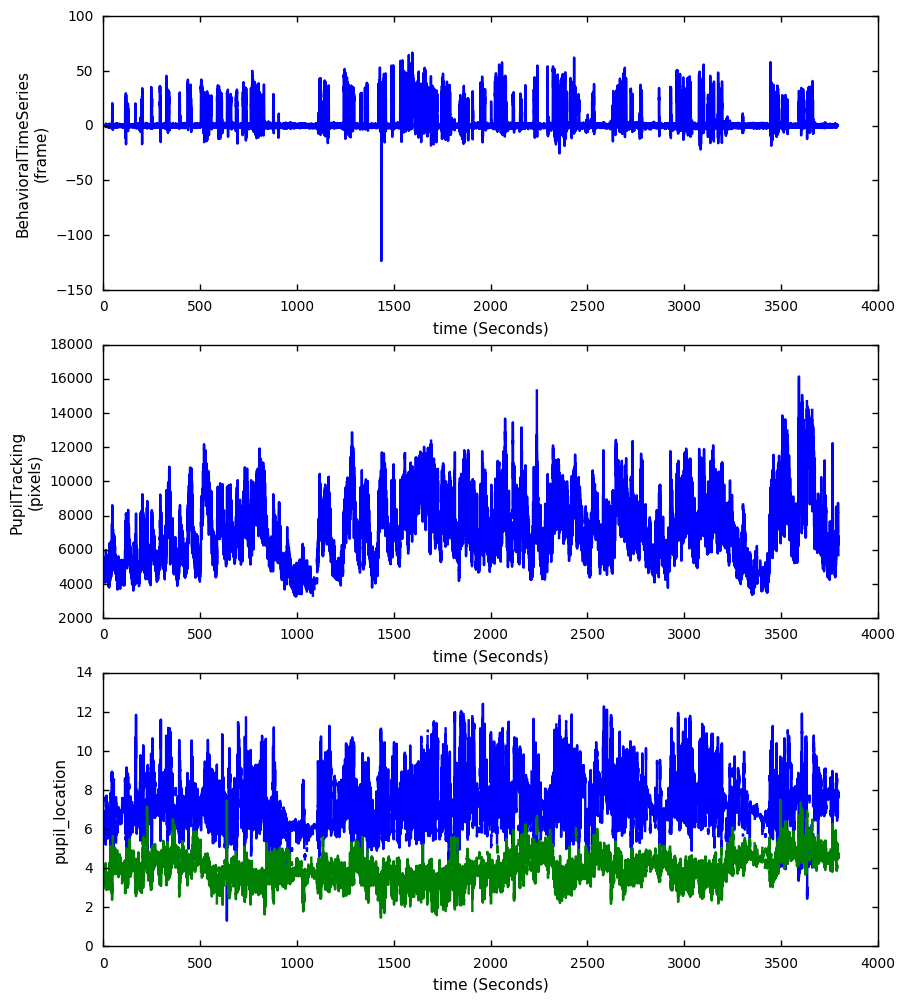

In [15]:
fig, axes = plt.subplots(3,1, figsize=(10,12))
for ii, container_name in enumerate(['BehavioralTimeSeries', 'PupilTracking']):
    ax = axes[ii]
    ds = pipeline.get_container(container_name)
    ts = ds.time_series
    data = ts.data.value
    timestamps = ts.timestamps.value


    ax.plot(timestamps, data)
    ax.set_xlabel('time (%s)' % ts.timestamps_unit)
    ax.set_ylabel('%s\n(%s)' % (ds.name, ts.unit))
    
ds = pipeline.get_container('EyeTracking')
for ss in ds.spatial_series:
    if ss.name == 'pupil_location':
    
        ax = axes[ii+1]
        data = ss.data.value
        timestamps = ss.timestamps.value


        ax.plot(timestamps, data, label='hi')
        ax.set_xlabel('time (%s)' % ss.timestamps_unit)
        ax.set_ylabel('%s' % (ss.name,))

Now lets look at the responses of some neurons in the imaging plaine. Lets plot a birds-eye view of the segmentation:

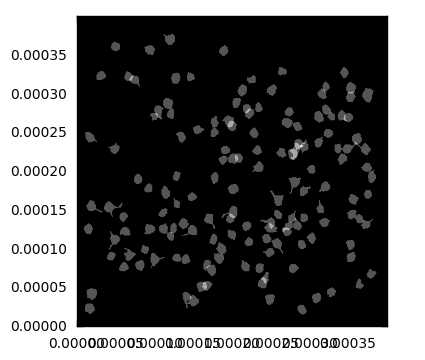

In [16]:
image_segmentation = pipeline.get_container('ImageSegmentation')
segmentation_mask = np.zeros(dimension)
extent = np.zeros(4)
extent[1] = field_of_view[0]
extent[3] = field_of_view[1]
for roi in image_segmentation.plane_segmentations[0].roi_list:
    segmentation_mask += roi.img_mask.value
_ = plt.imshow(segmentation_mask, cmap=plt.cm.gray, extent=extent)

Each of these segmented ROI's has a dF/F trace stored in the `DfOverF` processing module.  Lastly, we plot this data for each cell:

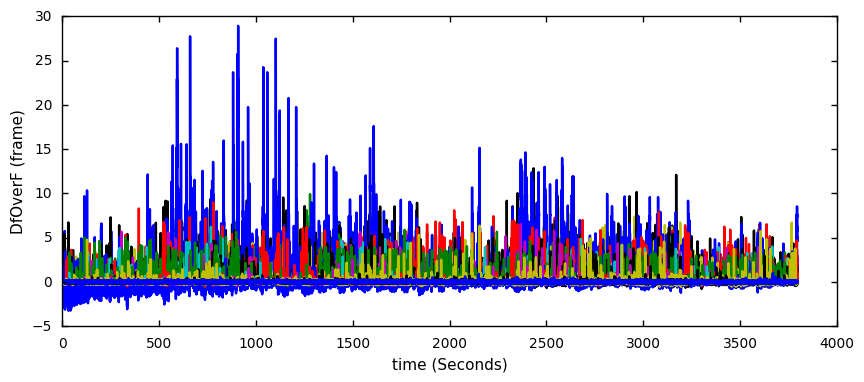

In [17]:
ds = pipeline.get_container('DfOverF')
ts = ds.roi_response_series[0]
timestamps = ts.timestamps.value
data = ts.data.value

fig, ax = plt.subplots(1,1, figsize=(10,4))
# plt.plot(timestamps, data.T)

ax.plot(timestamps, data.T)
ax.set_xlabel('time (%s)' % ts.timestamps_unit)
_ = ax.set_ylabel('%s (%s)' % (ds.name, ts.unit))